In [46]:
import sys
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spacy
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


if (dir := str(Path(os.getcwd()).parent)) not in sys.path:
    sys.path.append(dir)


from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier

from mylib.bag_of_words import BagOfWords
from mylib.tfidf import TfIdf
from mylib.pca import  PCA
from mylib.cart import CART
from mylib.naive_bayes import NaiveBayes


np.random.seed(73)

In [13]:
nlp = spacy.load("en_core_web_md")

## Работа с датасетом

In [14]:
df = pd.read_csv('../data/spam.csv', sep=',', encoding='latin-1')
df.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [16]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

df = df.astype('string')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   string
 1   v2      5572 non-null   string
dtypes: string(2)
memory usage: 87.2 KB


In [17]:
X = df.drop(columns=['v1'])
y = df['v1'].map({'ham': 0, 'spam': 1})

In [18]:
nlp.Defaults.stop_words.__len__()

326

In [19]:
str(nlp('.')) in set(string.punctuation)

True

In [20]:
docs = np.array([
    ' '.join([
        word.lemma_ for word in nlp(doc.lower())
        if str(word.lemma_) not in (nlp.Defaults.stop_words | set(string.punctuation) | {'..', '...'})
    ])
    for doc in np.array(X).reshape(-1,)
])

Пропуск стоп-слов сильно уменьшает документы (слишком?)

In [21]:
X[:2].values

array([['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'],
       ['Ok lar... Joking wif u oni...']], dtype=object)

In [22]:
docs[:2]

array(['jurong point crazy available bugis n great world la e buffet cine amore wat',
       'ok lar joke wif u oni'], dtype='<U462')

In [23]:
X_train, X_test, y_train, y_test = train_test_split(docs, y, test_size=0.33, stratify=y)

X_train.shape, X_test.shape

((3733,), (1839,))

In [24]:
def test_all(X_train, X_test, y_train, y_test, vectorizer, lower_dim, estimator, home_edition=False):
    if home_edition:
        X_train_vectorized = np.array(vectorizer.fit_transform(X_train))
        X_test_vectorized = np.array(vectorizer.transform(X_test))
    else:
        X_train_vectorized = np.array(vectorizer.fit_transform(X_train).todense())
        X_test_vectorized = np.array(vectorizer.transform(X_test).todense())

    print('X_train Vectorized:', X_train_vectorized.shape)
    print('X_test Vectorized:', X_test_vectorized.shape)
    
    X_train_lower_dim = lower_dim.fit_transform(X_train_vectorized, y_train)
    print('X_train lower dim:', X_train_lower_dim.shape)

    X_test_lower_dim = lower_dim.transform(X_test_vectorized)
    print('X_test lower dim:', X_test_lower_dim.shape)
    
    if X_train_lower_dim.shape[1] == 2:
        plt.title('График на тренировочных данных')
        plt.scatter(X_train_lower_dim[:, 0], X_train_lower_dim[:, 1], marker='o', c=y_train, s=20, edgecolor='k')
        plt.show()
    elif X_train_lower_dim.shape[1] == 3:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.set_title('График с тренировочными данными')
        ax.scatter(X_train_lower_dim[:, 0], X_train_lower_dim[:, 1], X_train_lower_dim[:, 2], c=y_train)
        plt.show()
    
    model = estimator.fit(X_train_lower_dim, y_train)
    
    y_test_pred = model.predict(X_test_lower_dim)

    print('Показатели на тестовых данных')
    print(classification_report(np.array(y_test), y_test_pred))

## Bag Of Words

### sklearn

**При использовании самописного PCA для понижения размерности приводит к комплексным признакам, с которыми не умеют работать некоторые модели**

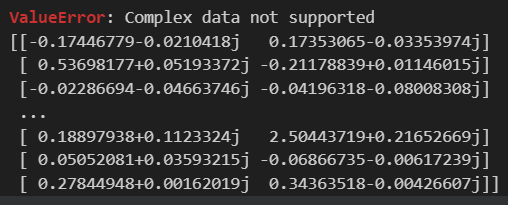

In [41]:
# test_all(X_train, X_test, y_train, y_test, CountVectorizer(), PCA(n_components=2), DecisionTreeClassifier())

**При использовании самописного CART для классификации порождается ошибка, что приводит к мысли использовать DecisionTreeClassifier из sklearn. Но попробовал еще самописный NaiveBayes**

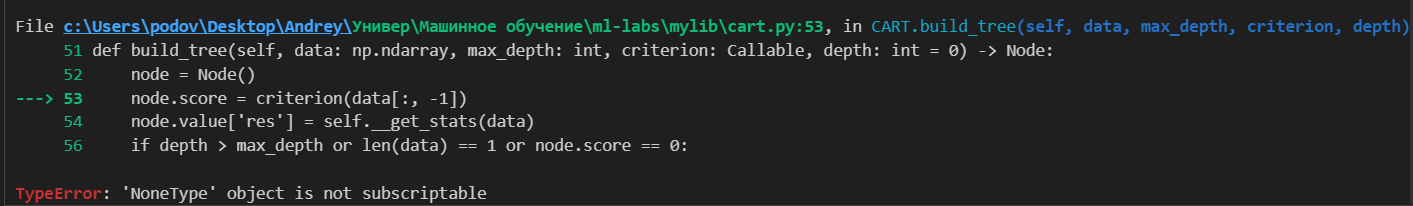

In [42]:
# test_all(X_train, X_test, y_train, y_test, CountVectorizer(), SelectKBest(k=2), CART('C'))

X_train Vectorized: (3733, 5946)
X_test Vectorized: (1839, 5946)
X_train lower dim: (3733, 2)
X_test lower dim: (1839, 2)


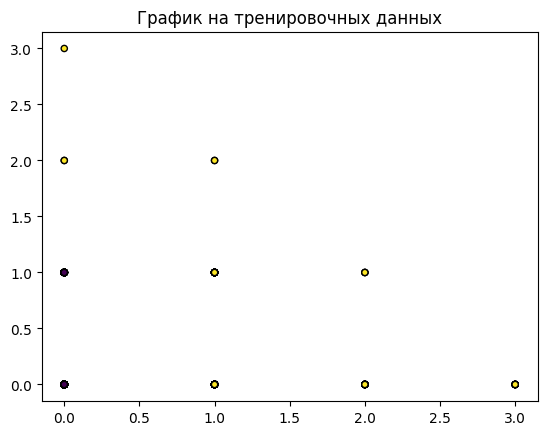

Показатели на тестовых данных
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1592
           1       0.77      0.34      0.47       247

    accuracy                           0.90      1839
   macro avg       0.84      0.66      0.71      1839
weighted avg       0.89      0.90      0.88      1839



In [43]:
test_all(X_train, X_test, y_train, y_test, CountVectorizer(), SelectKBest(k=2), DecisionTreeClassifier())

X_train Vectorized: (3733, 5946)
X_test Vectorized: (1839, 5946)
X_train lower dim: (3733, 3)
X_test lower dim: (1839, 3)


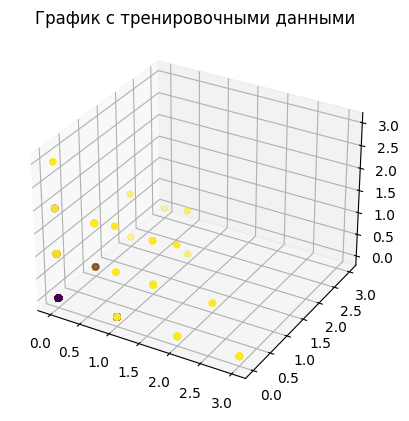

Показатели на тестовых данных
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1592
           1       0.80      0.45      0.57       247

    accuracy                           0.91      1839
   macro avg       0.86      0.71      0.76      1839
weighted avg       0.90      0.91      0.90      1839



In [44]:
test_all(X_train, X_test, y_train, y_test, CountVectorizer(), SelectKBest(k=3), DecisionTreeClassifier())

In [45]:
test_all(X_train, X_test, y_train, y_test, CountVectorizer(), SelectKBest(k=212), DecisionTreeClassifier())

X_train Vectorized: (3733, 5946)
X_test Vectorized: (1839, 5946)
X_train lower dim: (3733, 212)
X_test lower dim: (1839, 212)
Показатели на тестовых данных
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1592
           1       0.96      0.84      0.90       247

    accuracy                           0.97      1839
   macro avg       0.97      0.92      0.94      1839
weighted avg       0.97      0.97      0.97      1839



### Home Edition

X_train Vectorized: (3733, 6448)
X_test Vectorized: (1839, 6448)
X_train lower dim: (3733, 2)
X_test lower dim: (1839, 2)


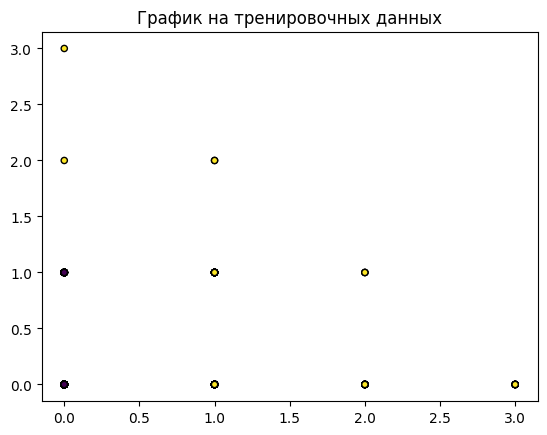

Показатели на тестовых данных
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1592
           1       0.76      0.34      0.47       247

    accuracy                           0.90      1839
   macro avg       0.83      0.66      0.71      1839
weighted avg       0.89      0.90      0.88      1839



In [15]:
test_all(X_train, X_test, y_train, y_test, BagOfWords(), SelectKBest(k=2), DecisionTreeClassifier(), True)

X_train Vectorized: (3733, 6448)
X_test Vectorized: (1839, 6448)
X_train lower dim: (3733, 3)
X_test lower dim: (1839, 3)


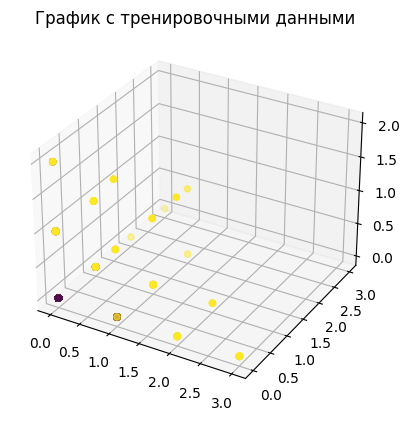

Показатели на тестовых данных
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1592
           1       0.79      0.44      0.57       247

    accuracy                           0.91      1839
   macro avg       0.85      0.71      0.76      1839
weighted avg       0.90      0.91      0.90      1839



In [17]:
test_all(X_train, X_test, y_train, y_test, BagOfWords(), SelectKBest(k=3), DecisionTreeClassifier(), True)

In [16]:
test_all(X_train, X_test, y_train, y_test, BagOfWords(), SelectKBest(k=212), DecisionTreeClassifier(), True)

X_train Vectorized: (3733, 6448)
X_test Vectorized: (1839, 6448)
X_train lower dim: (3733, 212)
X_test lower dim: (1839, 212)
Показатели на тестовых данных
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1592
           1       0.94      0.83      0.88       247

    accuracy                           0.97      1839
   macro avg       0.96      0.91      0.93      1839
weighted avg       0.97      0.97      0.97      1839



X_train Vectorized: (3733, 5946)
X_test Vectorized: (1839, 5946)
X_train lower dim: (3733, 2)
X_test lower dim: (1839, 2)


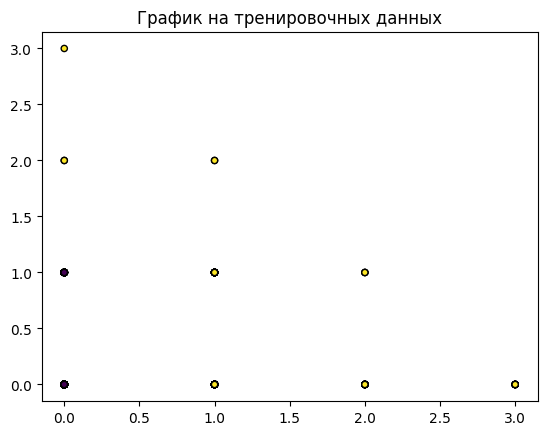

Показатели на тестовых данных
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1592
           1       0.77      0.34      0.47       247

    accuracy                           0.90      1839
   macro avg       0.84      0.66      0.71      1839
weighted avg       0.89      0.90      0.88      1839



In [49]:
test_all(X_train, X_test, y_train, y_test, CountVectorizer(), SelectKBest(k=2), NaiveBayes())

X_train Vectorized: (3733, 5946)
X_test Vectorized: (1839, 5946)
X_train lower dim: (3733, 3)
X_test lower dim: (1839, 3)


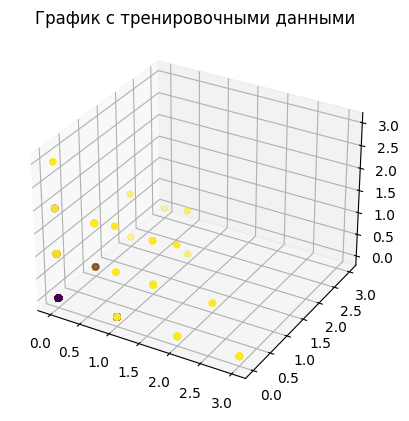

Показатели на тестовых данных
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1592
           1       0.79      0.45      0.57       247

    accuracy                           0.91      1839
   macro avg       0.86      0.71      0.76      1839
weighted avg       0.90      0.91      0.90      1839



In [50]:
test_all(X_train, X_test, y_train, y_test, CountVectorizer(), SelectKBest(k=3), NaiveBayes())

In [51]:
test_all(X_train, X_test, y_train, y_test, CountVectorizer(), SelectKBest(k=212), NaiveBayes())

X_train Vectorized: (3733, 5946)
X_test Vectorized: (1839, 5946)
X_train lower dim: (3733, 212)
X_test lower dim: (1839, 212)
Показатели на тестовых данных
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1592
           1       0.00      0.00      0.00       247

    accuracy                           0.87      1839
   macro avg       0.43      0.50      0.46      1839
weighted avg       0.75      0.87      0.80      1839



c:\Users\podov\Desktop\Andrey\Универ\Машинное обучение\ml-labs\mylib\naive_bayes.py:25: RuntimeWarning: divide by zero encountered in divide
  return np.exp(- (x - u)**2 / (2 * o**2)) / (o * sqrt(2*np.pi))
c:\Users\podov\Desktop\Andrey\Универ\Машинное обучение\ml-labs\mylib\naive_bayes.py:25: RuntimeWarning: invalid value encountered in divide
  return np.exp(- (x - u)**2 / (2 * o**2)) / (o * sqrt(2*np.pi))
c:\Users\podov\Desktop\Andrey\Универ\Машинное обучение\ml-labs\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\podov\Desktop\Andrey\Универ\Машинное обучение\ml-labs\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pre

## TfIdf

### sklearn

X_train Vectorized: (3733, 5946)
X_test Vectorized: (1839, 5946)
X_train lower dim: (3733, 2)
X_test lower dim: (1839, 2)


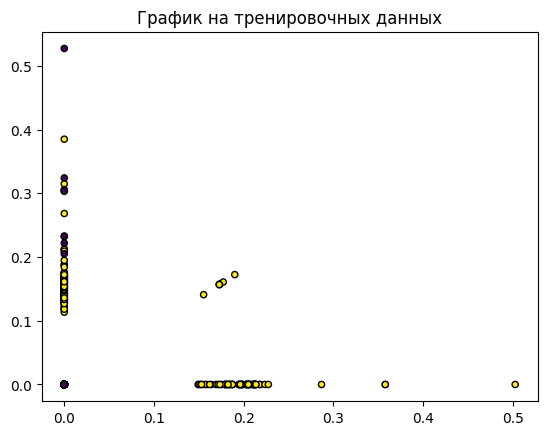

Показатели на тестовых данных
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1592
           1       0.95      0.33      0.49       247

    accuracy                           0.91      1839
   macro avg       0.93      0.66      0.72      1839
weighted avg       0.91      0.91      0.89      1839



In [46]:
test_all(X_train, X_test, y_train, y_test, TfidfVectorizer(), SelectKBest(k=2), DecisionTreeClassifier())

X_train Vectorized: (3733, 5946)
X_test Vectorized: (1839, 5946)
X_train lower dim: (3733, 2)
X_test lower dim: (1839, 2)


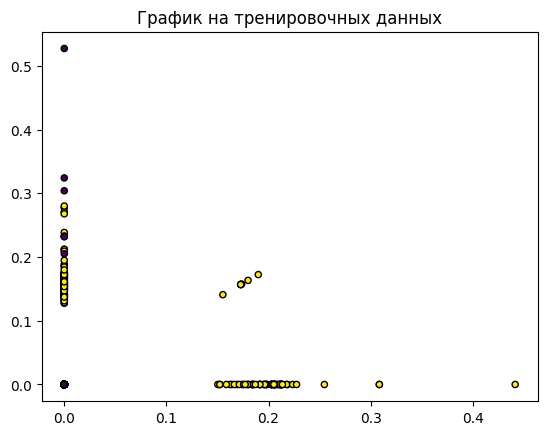

Показатели на тестовых данных
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1592
           1       0.95      0.33      0.49       247

    accuracy                           0.91      1839
   macro avg       0.93      0.66      0.72      1839
weighted avg       0.91      0.91      0.89      1839



In [47]:
test_all(X_train, X_test, y_train, y_test, TfidfVectorizer(sublinear_tf=True), SelectKBest(k=2), DecisionTreeClassifier())

X_train Vectorized: (3733, 5946)
X_test Vectorized: (1839, 5946)
X_train lower dim: (3733, 3)
X_test lower dim: (1839, 3)


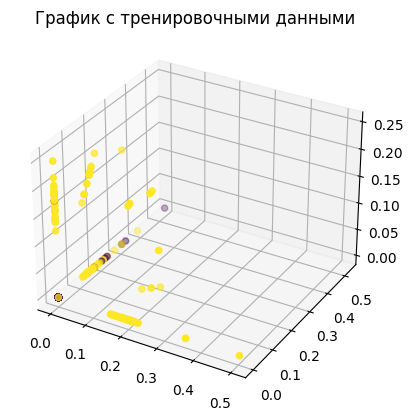

Показатели на тестовых данных
              precision    recall  f1-score   support

           0       0.92      1.00      0.95      1592
           1       0.96      0.41      0.57       247

    accuracy                           0.92      1839
   macro avg       0.94      0.70      0.76      1839
weighted avg       0.92      0.92      0.90      1839



In [49]:
test_all(X_train, X_test, y_train, y_test, TfidfVectorizer(), SelectKBest(k=3), DecisionTreeClassifier())

In [48]:
test_all(X_train, X_test, y_train, y_test, TfidfVectorizer(), SelectKBest(k=212), DecisionTreeClassifier())

X_train Vectorized: (3733, 5946)
X_test Vectorized: (1839, 5946)
X_train lower dim: (3733, 212)
X_test lower dim: (1839, 212)
Показатели на тестовых данных
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1592
           1       0.91      0.85      0.88       247

    accuracy                           0.97      1839
   macro avg       0.94      0.92      0.93      1839
weighted avg       0.97      0.97      0.97      1839



### Home Edition

X_train Vectorized: (3733, 6448)
X_test Vectorized: (1839, 6448)
X_train lower dim: (3733, 2)
X_test lower dim: (1839, 2)


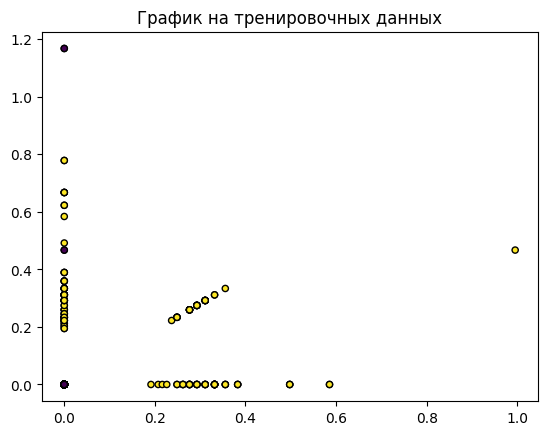

Показатели на тестовых данных
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1592
           1       0.98      0.26      0.41       247

    accuracy                           0.90      1839
   macro avg       0.94      0.63      0.68      1839
weighted avg       0.91      0.90      0.87      1839



In [14]:
test_all(X_train, X_test, y_train, y_test, TfIdf(), SelectKBest(k=2), DecisionTreeClassifier(), True)

X_train Vectorized: (3733, 6448)
X_test Vectorized: (1839, 6448)
X_train lower dim: (3733, 3)
X_test lower dim: (1839, 3)


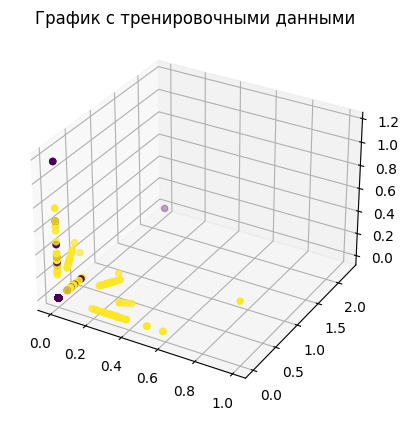

Показатели на тестовых данных
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1592
           1       0.94      0.39      0.55       247

    accuracy                           0.92      1839
   macro avg       0.93      0.69      0.75      1839
weighted avg       0.92      0.92      0.90      1839



In [15]:
test_all(X_train, X_test, y_train, y_test, TfIdf(), SelectKBest(k=3), DecisionTreeClassifier(), True)

In [16]:
test_all(X_train, X_test, y_train, y_test, TfIdf(), SelectKBest(k=212), DecisionTreeClassifier(), True)

X_train Vectorized: (3733, 6448)
X_test Vectorized: (1839, 6448)
X_train lower dim: (3733, 212)
X_test lower dim: (1839, 212)
Показатели на тестовых данных
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1592
           1       0.92      0.85      0.88       247

    accuracy                           0.97      1839
   macro avg       0.95      0.92      0.93      1839
weighted avg       0.97      0.97      0.97      1839



X_train Vectorized: (3733, 6448)
X_test Vectorized: (1839, 6448)
X_train lower dim: (3733, 2)
X_test lower dim: (1839, 2)


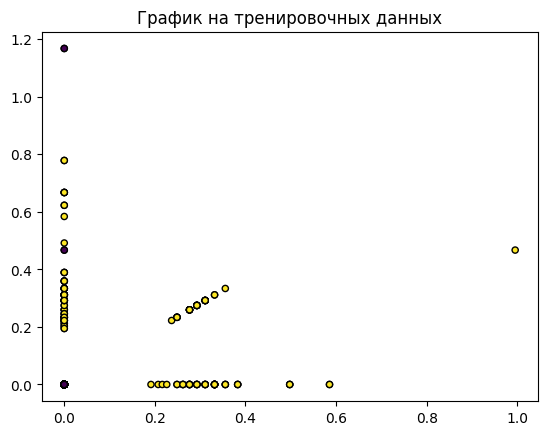

Показатели на тестовых данных
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1592
           1       0.00      0.00      0.00       247

    accuracy                           0.87      1839
   macro avg       0.43      0.50      0.46      1839
weighted avg       0.75      0.87      0.80      1839



c:\Users\podov\Desktop\Andrey\Универ\Машинное обучение\ml-labs\mylib\naive_bayes.py:25: RuntimeWarning: divide by zero encountered in divide
  return np.exp(- (x - u)**2 / (2 * o**2)) / (o * sqrt(2*np.pi))
c:\Users\podov\Desktop\Andrey\Универ\Машинное обучение\ml-labs\mylib\naive_bayes.py:25: RuntimeWarning: invalid value encountered in divide
  return np.exp(- (x - u)**2 / (2 * o**2)) / (o * sqrt(2*np.pi))
c:\Users\podov\Desktop\Andrey\Универ\Машинное обучение\ml-labs\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\podov\Desktop\Andrey\Универ\Машинное обучение\ml-labs\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pre

In [52]:
test_all(X_train, X_test, y_train, y_test, TfIdf(), SelectKBest(k=2), NaiveBayes(), True)

X_train Vectorized: (3733, 6448)
X_test Vectorized: (1839, 6448)
X_train lower dim: (3733, 3)
X_test lower dim: (1839, 3)


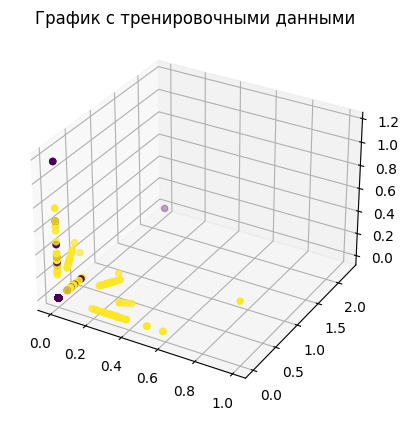

Показатели на тестовых данных
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1592
           1       0.94      0.39      0.55       247

    accuracy                           0.92      1839
   macro avg       0.93      0.69      0.75      1839
weighted avg       0.92      0.92      0.90      1839



In [53]:
test_all(X_train, X_test, y_train, y_test, TfIdf(), SelectKBest(k=3), DecisionTreeClassifier(), True)

In [54]:
test_all(X_train, X_test, y_train, y_test, TfIdf(), SelectKBest(k=212), DecisionTreeClassifier(), True)

X_train Vectorized: (3733, 6448)
X_test Vectorized: (1839, 6448)
X_train lower dim: (3733, 212)
X_test lower dim: (1839, 212)
Показатели на тестовых данных
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1592
           1       0.91      0.85      0.88       247

    accuracy                           0.97      1839
   macro avg       0.94      0.92      0.93      1839
weighted avg       0.97      0.97      0.97      1839



## LDA

In [35]:
n_topics = 2
n_top_words = 25

In [36]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = vectorizer.fit_transform(X_train)
tf.shape

(3733, 2618)

In [37]:
lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=33,
    learning_method='online',
    learning_offset=50.,
    random_state=73
).fit(tf)

In [38]:
lda.components_, lda.components_.shape

(array([[ 0.54037654,  0.50162671,  0.50103722, ...,  2.61540119,
         35.49262675,  4.24766062],
        [ 4.41976661, 13.71763046,  2.54794542, ...,  0.52984522,
          0.54047836,  0.62494062]]),
 (2, 2618))

In [33]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [41]:
print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words)

Topic #0:
come ok know good gt lt like day time love want tell need think lor ur home work ask sorry oh later hope night da
Topic #1:
free text reply ur txt send stop win phone mobile min new number claim message try contact www prize uk cash week msg urgent service


In [57]:
lda_x = lda.transform(tf)
model = DecisionTreeClassifier().fit(lda_x, y_train)

y_pred = model.predict(lda.transform(vectorizer.transform(X_test)))
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1592
           1       0.83      0.79      0.81       247

    accuracy                           0.95      1839
   macro avg       0.90      0.88      0.89      1839
weighted avg       0.95      0.95      0.95      1839



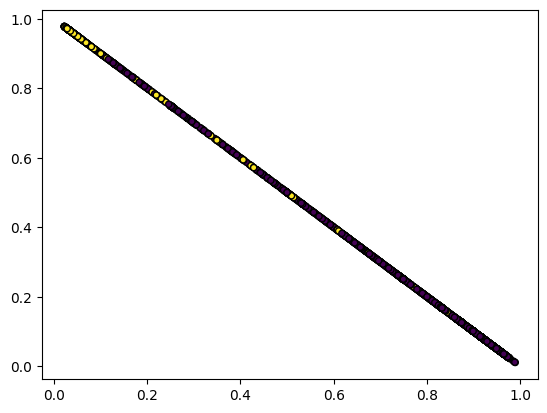

In [59]:
plt.scatter(lda_x[:, 0], lda_x[:, 1], marker='o', c=y_train, s=20, edgecolor='k')